In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import re
from datetime import datetime
import os

from tensorboard.plugins.hparams import api as hp

from sklearn.metrics import confusion_matrix
import seaborn as sns

import datetime as dt

from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score


## Fashion MNIST

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(fashion_train_images, fashion_train_labels), (fashion_test_images, fashion_test_labels) = fashion_mnist.load_data()

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

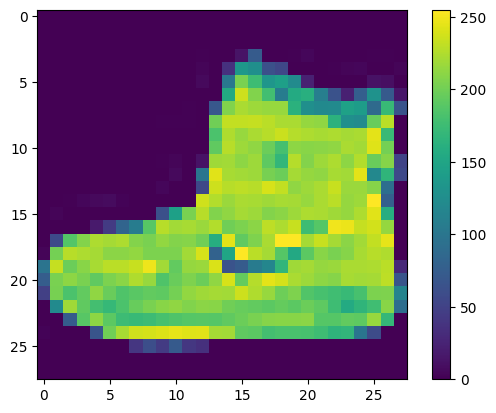

In [5]:
plt.figure()
plt.imshow(fashion_train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the training set and the testing set be preprocessed in the same way:

In [6]:
fashion_train_images = fashion_train_images / 255.0
fashion_test_images = fashion_test_images / 255.0

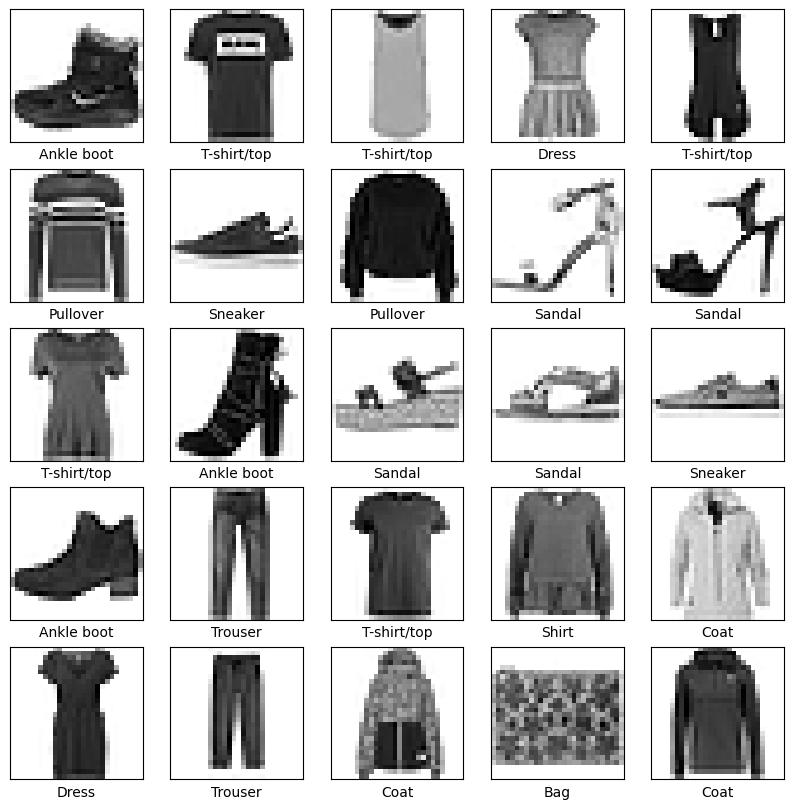

In [7]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(fashion_train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[fashion_train_labels[i]])
plt.show()

In [8]:
batch_size = 32
num_classes = 10
epochs = 2

row_hidden = 64
col_hidden = 64

In [9]:
# Input layer
input_layer = tf.keras.Input(shape=(28, 28))

# Permute the dimensions for column-wise processing
permuted_input = tf.keras.layers.Permute((2, 1))(input_layer)

# First branch with two 1D convolutional layers followed by a bidirectional LSTM
x1 = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(input_layer)
x1 = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(x1)
x1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x1)
x1 = tf.keras.layers.LSTM(64, name='LSTM_left')(x1)

# Second branch with permuted input, two 1D convolutional layers, and a bidirectional LSTM
x2 = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(permuted_input)
x2 = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(x2)
x2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x2)
x2 = tf.keras.layers.LSTM(64, name='LSTM_right')(x2)

# Concatenate the outputs of the two branches
concatenated = tf.keras.layers.Concatenate()([x1, x2])

# Apply dropout
dropout = tf.keras.layers.Dropout(0.2)(concatenated)

# Output layer
output_layer = tf.keras.layers.Dense(10, activation='softmax')(dropout)

# Create the model
model_fashion_lstm = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model_fashion_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model_fashion_lstm.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 28, 28)    │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 28, 64)    │      5,440 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 28, 64)    │      5,440 │ permute[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 28, 64)    │     12,352 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 28, 64)    │     12,352 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 28, 128)   │     66,048 │ conv1d_1[0][0]    │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 28, 128)   │     66,048 │ conv1d_3[0][0]    │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM_left (LSTM)    │ (None, 64)        │     49,408 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM_right (LSTM)   │ (None, 64)        │     49,408 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ LSTM_left[0][0],  │
│ (Concatenate)       │                   │            │ LSTM_right[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10)        │      1,290 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 267,786 (1.02 MB)

 Trainable params: 267,786 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model_fashion_lstm.fit(fashion_train_images, fashion_train_labels, epochs=2, batch_size=batch_size)

Epoch 1/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 95s 49ms/step - accuracy: 0.7312 - loss: 0.7339
Epoch 2/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 84s 45ms/step - accuracy: 0.8537 - loss: 0.3962


In [11]:
LSTM_right_layer = model_fashion_lstm.get_layer('LSTM_right')
LSTM_left_layer = model_fashion_lstm.get_layer('LSTM_left')

original_weights_right = model_fashion_lstm.get_layer('LSTM_right').get_weights()
original_weights_left = model_fashion_lstm.get_layer('LSTM_left').get_weights()

In [12]:
test_loss, test_acc = model_fashion_lstm.evaluate(fashion_test_images, fashion_test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 106s - 337ms/step - accuracy: 0.8628 - loss: 0.3898

Test accuracy: 0.8628000020980835


In [22]:
# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'model/Fashion_LSTM___Date_Time_{current_date_time_string}___Loss_{test_loss}___Accuracy_{test_acc}.keras'

# Save the Model.
model_fashion_lstm.save(model_file_name)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
0.8628


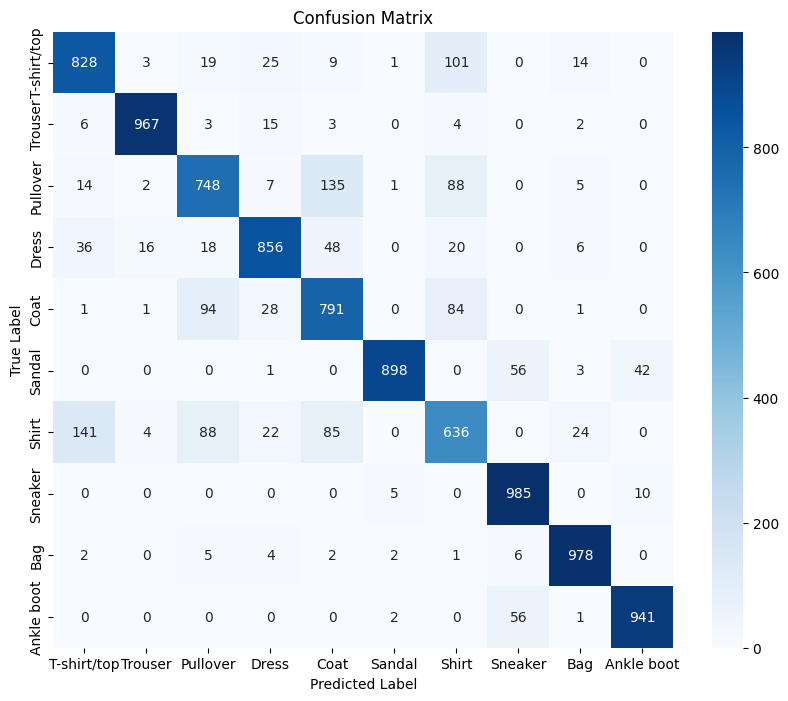

In [13]:
# Predict the classes of the test images
predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
accuracy = accuracy_score(fashion_test_labels, predicted_classes)
print(accuracy)

# Generate the confusion matrix
cm = confusion_matrix(fashion_test_labels, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [86]:
import sys
sys.path.append('/Users/justin/Desktop/Year 4/FYP/main')
from iterative_approximation.Algorithm1 import *

import statistics

In [15]:
def approximate_weight_step(Nsteps, NZ, Tr, Tc, layer1, layer2):

    # For standard Keras LSTM layers, the ordering within these is [input_gate, forget_gate, cell_state, output_gate]
    kernel1, recurrent_kernel1, bias1 = layer1.get_weights()

    kernel2, recurrent_kernel2, bias2 = layer2.get_weights()
    

    input_len = kernel1[:, :layer1.units].shape[0]

    # Input gate weights and biases
    i = Weight()
    i.init_weight(np.vstack((kernel1[:, :layer1.units],recurrent_kernel1[:, :layer1.units])))
    i_approximated = i.iterative_approximation_step(NZ, Nsteps, Tc, Tr)

    W_i_approximated = i_approximated[:,:input_len]
    H_i_approximated = i_approximated[:,input_len:]

    f = Weight()
    f.init_weight(np.vstack((kernel1[:, layer1.units:layer1.units*2],recurrent_kernel1[:, layer1.units:layer1.units*2])))
    f_approximated = f.iterative_approximation_step(NZ, Nsteps, Tc, Tr)

    W_f_approximated = f_approximated[:,:input_len]
    H_f_approximated = f_approximated[:,input_len:]


    o = Weight()
    o.init_weight(np.vstack((kernel1[:, layer1.units*2:layer1.units*3],recurrent_kernel1[:, layer1.units*2:layer1.units*3])))
    o_approximated = o.iterative_approximation_step(NZ, Nsteps, Tc, Tr)

    W_o_approximated = o_approximated[:,:input_len]
    H_o_approximated = o_approximated[:,input_len:]

    c = Weight()
    c.init_weight(np.vstack((kernel1[:, layer1.units*3:],recurrent_kernel1[:, layer1.units*3:])))
    c_approximated = c.iterative_approximation_step(NZ, Nsteps, Tc, Tr)

    W_c_approximated = c_approximated[:,:input_len]
    H_c_approximated = c_approximated[:,input_len:]

    W_compression_ratio= statistics.mean([i.compression_ratio(), f.compression_ratio(), o.compression_ratio(), c.compression_ratio()])
    H_compression_ratio= statistics.mean([i.compression_ratio(), f.compression_ratio(), o.compression_ratio(), c.compression_ratio()])

    approximated_kernel = np.hstack((np.transpose(W_i_approximated), np.transpose(W_f_approximated), np.transpose(W_o_approximated), np.transpose(W_c_approximated)))
    approximated_recurrent_kernel = np.hstack((np.transpose(H_i_approximated), np.transpose(H_f_approximated), np.transpose(H_o_approximated), np.transpose(H_c_approximated)))

    return approximated_kernel, approximated_recurrent_kernel, W_compression_ratio, H_compression_ratio

In [16]:
def approximate_weight2_step(Nsteps, NZ, Tr, Tc, layer):

    # For standard Keras LSTM layers, the ordering within these is [input_gate, forget_gate, cell_state, output_gate]
    kernel, recurrent_kernel, bias = layer.get_weights()

    input_len = kernel[:, :layer.units].shape[0]

    # Input gate weights and biases
    i = Weight()
    i.init_weight(np.vstack((kernel[:, :layer.units],recurrent_kernel[:, :layer.units])))
    i_approximated = i.iterative_approximation_step(NZ, Nsteps, Tc, Tr)

    W_i_approximated = i_approximated[:,:input_len]
    H_i_approximated = i_approximated[:,input_len:]

    f = Weight()
    f.init_weight(np.vstack((kernel[:, layer.units:layer.units*2],recurrent_kernel[:, layer.units:layer.units*2])))
    f_approximated = f.iterative_approximation_step(NZ, Nsteps, Tc, Tr)

    W_f_approximated = f_approximated[:,:input_len]
    H_f_approximated = f_approximated[:,input_len:]


    o = Weight()
    o.init_weight(np.vstack((kernel[:, layer.units*2:layer.units*3],recurrent_kernel[:, layer.units*2:layer.units*3])))
    o_approximated = o.iterative_approximation_step(NZ, Nsteps, Tc, Tr)

    W_o_approximated = o_approximated[:,:input_len]
    H_o_approximated = o_approximated[:,input_len:]

    c = Weight()
    c.init_weight(np.vstack((kernel[:, layer.units*3:],recurrent_kernel[:, layer.units*3:])))
    c_approximated = c.iterative_approximation_step(NZ, Nsteps, Tc, Tr)

    W_c_approximated = c_approximated[:,:input_len]
    H_c_approximated = c_approximated[:,input_len:]

    W_compression_ratio= statistics.mean([i.compression_ratio(), f.compression_ratio(), o.compression_ratio(), c.compression_ratio()])
    H_compression_ratio= statistics.mean([i.compression_ratio(), f.compression_ratio(), o.compression_ratio(), c.compression_ratio()])

    approximated_kernel = np.hstack((np.transpose(W_i_approximated), np.transpose(W_f_approximated), np.transpose(W_o_approximated), np.transpose(W_c_approximated)))
    approximated_recurrent_kernel = np.hstack((np.transpose(H_i_approximated), np.transpose(H_f_approximated), np.transpose(H_o_approximated), np.transpose(H_c_approximated)))

    return approximated_kernel, approximated_recurrent_kernel, W_compression_ratio, H_compression_ratio

In [17]:
def cross_approximate_weight2_step(Nsteps, NZ, Tr, Tc, layer1, layer2):

    # For standard Keras LSTM layers, the ordering within these is [input_gate, forget_gate, cell_state, output_gate]
    kernel1, recurrent_kernel1, bias1 = layer1.get_weights()
    kernel2, recurrent_kernel2, bias2 = layer2.get_weights()

    input_len = kernel1.shape[0]
    hidden_len = recurrent_kernel1.shape[0]

    # Input gate weights and biases
    i = Weight()
    i.init_weight(np.hstack((np.vstack((kernel1[:, layer1.units*2:layer1.units*3], recurrent_kernel1[:, layer1.units*2:layer1.units*3])),np.vstack((kernel2[:, layer1.units*2:layer1.units*3], recurrent_kernel2[:, layer1.units*2:layer1.units*3])))))
    i_approximated = i.iterative_approximation_step(NZ, Nsteps, Tc, Tr)
    W_i_approximated1 = i_approximated[:hidden_len,:input_len]
    H_i_approximated1 = i_approximated[:hidden_len,input_len:]
    W_i_approximated2 = i_approximated[hidden_len:,:input_len]
    H_i_approximated2 = i_approximated[hidden_len:,input_len:]

    f = Weight()
    
    f.init_weight(np.hstack((np.vstack((kernel1[:, layer1.units:layer1.units*2],recurrent_kernel1[:, layer1.units:layer1.units*2])),np.vstack((kernel2[:, layer1.units:layer1.units*2],recurrent_kernel2[:, layer1.units:layer1.units*2])))))
    f_approximated = f.iterative_approximation_step(NZ, Nsteps, Tc, Tr)

    W_f_approximated1 = f_approximated[:hidden_len,:input_len]
    H_f_approximated1 = f_approximated[:hidden_len,input_len:]
    W_f_approximated2 = f_approximated[hidden_len:,:input_len]
    H_f_approximated2 = f_approximated[hidden_len:,input_len:]


    o = Weight()
    o.init_weight(np.hstack((np.vstack((kernel1[:, layer1.units*2:layer1.units*3],recurrent_kernel1[:, layer1.units*2:layer1.units*3])),np.vstack((kernel2[:, layer1.units*2:layer1.units*3],recurrent_kernel2[:, layer1.units*2:layer1.units*3])))))
    o_approximated = o.iterative_approximation_step(NZ, Nsteps, Tc, Tr)

    W_o_approximated1 = o_approximated[:hidden_len,:input_len]
    H_o_approximated1 = o_approximated[:hidden_len,input_len:]
    W_o_approximated2 = o_approximated[hidden_len:,:input_len]
    H_o_approximated2 = o_approximated[hidden_len:,input_len:]

    c = Weight()
    c.init_weight(np.hstack((np.vstack((kernel1[:, layer1.units*3:],recurrent_kernel1[:, layer1.units*3:])),np.vstack((kernel2[:, layer1.units*3:],recurrent_kernel2[:, layer1.units*3:])))))
    c_approximated = c.iterative_approximation_step(NZ, Nsteps, Tc, Tr)

    W_c_approximated1 = c_approximated[:hidden_len,:input_len]
    H_c_approximated1 = c_approximated[:hidden_len,input_len:]
    W_c_approximated2 = c_approximated[hidden_len:,:input_len]
    H_c_approximated2 = c_approximated[hidden_len:,input_len:]

    W_compression_ratio= statistics.mean([i.compression_ratio(), f.compression_ratio(), o.compression_ratio(), c.compression_ratio()])
    H_compression_ratio= statistics.mean([i.compression_ratio(), f.compression_ratio(), o.compression_ratio(), c.compression_ratio()])

    approximated_kernel1 = np.hstack((np.transpose(W_i_approximated1), np.transpose(W_f_approximated1), np.transpose(W_o_approximated1), np.transpose(W_c_approximated1)))
    approximated_recurrent_kernel1 = np.hstack((np.transpose(H_i_approximated1), np.transpose(H_f_approximated1), np.transpose(H_o_approximated1), np.transpose(H_c_approximated1)))

    approximated_kernel2 = np.hstack((np.transpose(W_i_approximated2), np.transpose(W_f_approximated2), np.transpose(W_o_approximated2), np.transpose(W_c_approximated2)))
    approximated_recurrent_kernel2 = np.hstack((np.transpose(H_i_approximated2), np.transpose(H_f_approximated2), np.transpose(H_o_approximated2), np.transpose(H_c_approximated2)))

    return approximated_kernel1, approximated_recurrent_kernel1, approximated_kernel2, approximated_recurrent_kernel2, W_compression_ratio, H_compression_ratio

[30, 66, 102, 138, 174]
  1/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step

/var/folders/6l/tkj8jq4d2c1fvr2j6g1kj0n40000gn/T/ipykernel_10444/1580164120.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = get_cmap('viridis')


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15

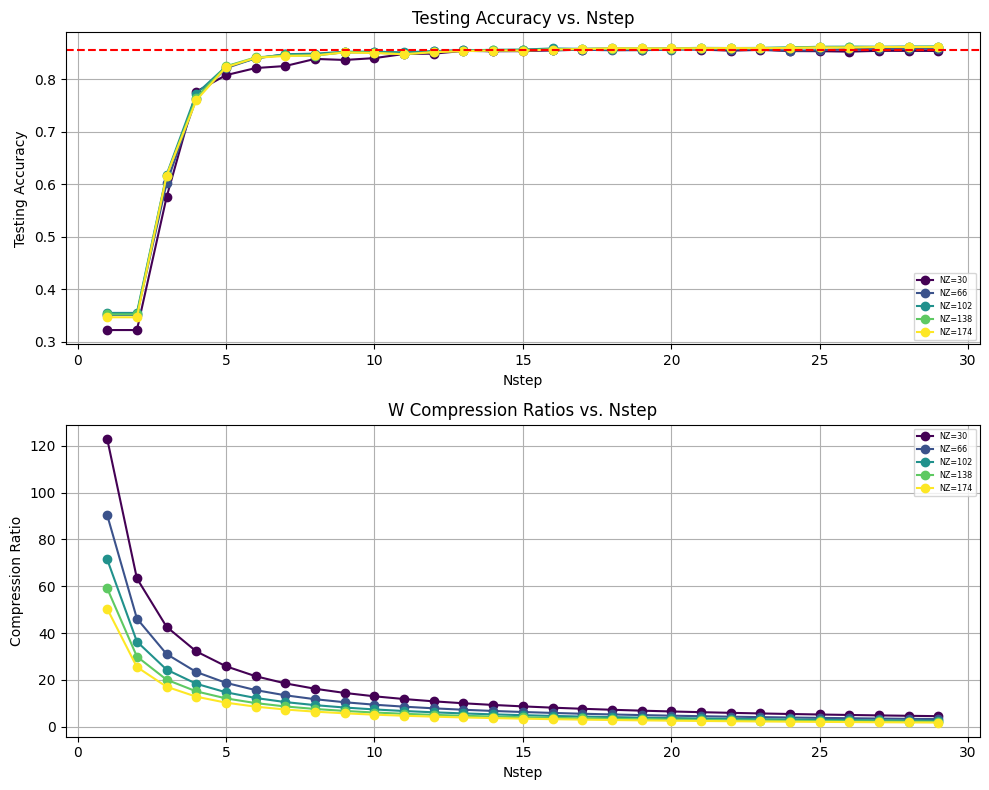

In [18]:
from matplotlib.cm import get_cmap

Tr = 1
Tc = 1

NZ_list = list(range(30, 192 + 1, 36))
Nstep_list = list(range(1,30,1))
print(NZ_list)

# Define color map
color_map = get_cmap('viridis')
colors = color_map(np.linspace(0, 1, len(NZ_list)))

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

for nz_index, NZ in enumerate(NZ_list):
    # Reset metrics for each NZ value
    testing_accuracies_nz = []
    W_compression_ratios_nz = []

    for Nstep in Nstep_list:
        # Reset to original weights before each approximation
        model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
        model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

        LSTM_right_layer = model_fashion_lstm.get_layer('LSTM_right')
        LSTM_left_layer = model_fashion_lstm.get_layer('LSTM_left')

        # Perform weight approximation
        approximated_kernel, approximated_recurrent_kernel, W_compression_ratio_right, H_compression_ratio = approximate_weight2_step(Nstep, NZ, Tr, Tc, LSTM_right_layer)

        # Set the approximated weights
        approximated_weights = [approximated_kernel, approximated_recurrent_kernel, original_weights_right[2]]
        model_fashion_lstm.get_layer('LSTM_right').set_weights(approximated_weights)

        # Perform weight approximation
        approximated_kernel, approximated_recurrent_kernel, W_compression_ratio_left, H_compression_ratio = approximate_weight2_step(Nstep, NZ, Tr, Tc, LSTM_left_layer)

        # Set the approximated weights
        approximated_weights = [approximated_kernel, approximated_recurrent_kernel, original_weights_left[2]]
        model_fashion_lstm.get_layer('LSTM_left').set_weights(approximated_weights)

        # Make predictions and evaluate the model with approximated weights
        predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
        accuracy = accuracy_score(fashion_test_labels, predicted_classes)

        W_compression_ratio = (W_compression_ratio_left + W_compression_ratio_right) / 2

        # Collect metrics for the current NZ value
        testing_accuracies_nz.append(accuracy)
        W_compression_ratios_nz.append(W_compression_ratio)

    # Plotting for the current NZ value with its corresponding color
    color = colors[nz_index]
    axs[0].plot(Nstep_list, testing_accuracies_nz, marker='o', linestyle='-', color=color, label=f'NZ={NZ}')
    axs[1].plot(Nstep_list, W_compression_ratios_nz, marker='o', linestyle='-', color=color, label=f'NZ={NZ}')

# Restore original weights after all approximations
model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

# Testing Accuracy vs. MSE Threshold Plot
axs[0].set_title('Testing Accuracy vs. Nstep')
axs[0].set_xlabel('Nstep')
axs[0].set_ylabel('Testing Accuracy')
axs[0].grid(True)
axs[0].legend(loc='lower right', fontsize='xx-small')
axs[0].axhline(y=0.8552, color='red', linestyle='--')

# W Compression Ratios vs. MSE Threshold Plot
axs[1].set_title('W Compression Ratios vs. Nstep')
axs[1].set_xlabel('Nstep')
axs[1].set_ylabel('Compression Ratio')
axs[1].grid(True)
axs[1].legend(loc='upper right', fontsize='xx-small')

plt.tight_layout()
plt.show()

In [80]:
model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

LSTM_right_layer = model_fashion_lstm.get_layer('LSTM_right')
LSTM_left_layer = model_fashion_lstm.get_layer('LSTM_left')

kernel1 shape
(128, 256)
recurrent kernel1 shape
(64, 256)
128
64
hhhh shape
(192, 64)
layer1 unit
64
i approximated shape
(128, 192)
W i approximated shape
(64, 128)
H i approximated shape
(64, 64)
(128, 256)
(64, 256)


/var/folders/6l/tkj8jq4d2c1fvr2j6g1kj0n40000gn/T/ipykernel_10444/536873835.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = get_cmap('viridis')


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22

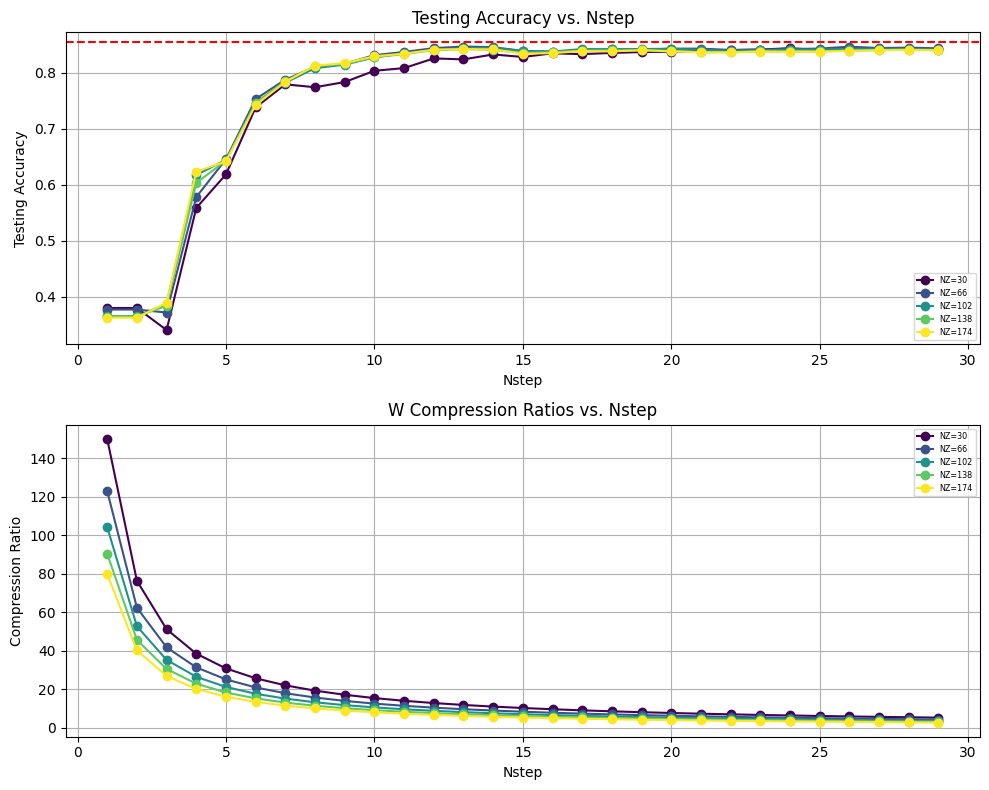

In [23]:
from matplotlib.cm import get_cmap

Tr = 1
Tc = 1

NZ_list = list(range(30, 192 + 1, 36))
Nstep_list = list(range(1,30,1))

# Define color map
color_map = get_cmap('viridis')
colors = color_map(np.linspace(0, 1, len(NZ_list)))

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

for nz_index, NZ in enumerate(NZ_list):
    # Reset metrics for each NZ value
    testing_accuracies_nz = []
    W_compression_ratios_nz = []

    for Nstep in Nstep_list:
        # Reset to original weights before each approximation
        model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
        model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

        LSTM_right_layer = model_fashion_lstm.get_layer('LSTM_right')
        LSTM_left_layer = model_fashion_lstm.get_layer('LSTM_left')

        # Perform weight approximation
        approximated_kernel1, approximated_recurrent_kernel1, approximated_kernel2, approximated_recurrent_kernel2, W_compression_ratio, H_compression_ratio = cross_approximate_weight2_step(Nstep, NZ, Tr, Tc, LSTM_right_layer, LSTM_left_layer)

        # Set the approximated weights
        approximated_weights1 = [approximated_kernel1, approximated_recurrent_kernel1, original_weights_right[2]]
        model_fashion_lstm.get_layer('LSTM_right').set_weights(approximated_weights1)

        # Set the approximated weights
        approximated_weights2 = [approximated_kernel2, approximated_recurrent_kernel2, original_weights_left[2]]
        model_fashion_lstm.get_layer('LSTM_left').set_weights(approximated_weights2)

        # Make predictions and evaluate the model with approximated weights
        predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
        accuracy = accuracy_score(fashion_test_labels, predicted_classes)

        # Collect metrics for the current NZ value
        testing_accuracies_nz.append(accuracy)
        W_compression_ratios_nz.append(W_compression_ratio)

    # Plotting for the current NZ value with its corresponding color
    color = colors[nz_index]
    axs[0].plot(Nstep_list, testing_accuracies_nz, marker='o', linestyle='-', color=color, label=f'NZ={NZ}')
    axs[1].plot(Nstep_list, W_compression_ratios_nz, marker='o', linestyle='-', color=color, label=f'NZ={NZ}')

# Restore original weights after all approximations
model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

# Testing Accuracy vs. MSE Threshold Plot
axs[0].set_title('Testing Accuracy vs. Nstep')
axs[0].set_xlabel('Nstep')
axs[0].set_ylabel('Testing Accuracy')
axs[0].grid(True)
axs[0].legend(loc='lower right', fontsize='xx-small')
axs[0].axhline(y=0.8552, color='red', linestyle='--')

# W Compression Ratios vs. MSE Threshold Plot
axs[1].set_title('W Compression Ratios vs. Nstep')
axs[1].set_xlabel('Nstep')
axs[1].set_ylabel('Compression Ratio')
axs[1].grid(True)
axs[1].legend(loc='upper right', fontsize='xx-small')

plt.tight_layout()
plt.show()

In [14]:
import sys
sys.path.append('/Users/justin/Desktop/Year 4/FYP/Code')
from iterative_approximation.Algorithm2 import *
from iterative_approximation.Algorithm2Step import *
from iterative_approximation.Algorithm1 import *
import itertools
from utils.generate_groupings import *
import matplotlib.cm as cm

In [21]:
def evaluation1(weight_array):
    W = WeightArray(weight_array)
    Nsteps = range(1, 20)

    MSE_values = {}  # Dictionary to hold MSE values for different thresholds
    threshold_list = [0.0001, 0.001, 0.01]

    for threshold in threshold_list:
        MSE_values[threshold] = []  # Initialize an empty list for each threshold
        for Nstep in Nsteps:
            # Your function to get a reconstructed matrix
            reconstructed = W.iterative_approximation_step(Nstep, threshold)
            # Your function to calculate MSE
            MSE = mean_square_error_array(reconstructed, weight_array)
            MSE_values[threshold].append(np.mean(MSE))  # Store the average MSE for this threshold and Nstep

    # Plotting
    plt.figure(figsize=(10, 6))
    for threshold, mse_list in MSE_values.items():
        plt.plot(Nsteps, mse_list, label=f'Threshold = {threshold:.5f}')

    plt.xlabel('Nstep')
    plt.ylabel('Mean Squared Error')
    plt.yscale('log')
    plt.title('Average MSE vs Nstep for Different Thresholds')
    plt.legend()
    plt.grid(True)
    plt.show()

def evaluation2(weight_array, yscale='normal'):
    W = WeightArray(weight_array)
    Nsteps = range(1, 50)

    MSE_values = []  # List to hold MSE values for different Nsteps
    compression_ratio = []  # List to hold compression ratios for different Nsteps

    threshold = 0.0001

    for Nstep in Nsteps:
        # Your function to get a reconstructed matrix
        reconstructed = W.iterative_approximation_step(Nstep, threshold)
        # Your function to calculate MSE
        MSE = mean_square_error_array(reconstructed, weight_array)
        MSE_values.append(MSE)  # Store the MSE for this Nstep
        compression_ratio.append(W.compression_ratio())  # Store the compression ratio for this Nstep

    # Creating a figure to hold both subplots
    plt.figure(figsize=(20, 6))

    # Subplot 1: MSE vs Nstep
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    colors = plt.cm.viridis(np.linspace(0, 1, len(weight_array)))
    for idx, weight in enumerate(weight_array):
        # Extract the MSE series for the current weight across all Nsteps
        mse_series = [MSE_values[step][idx] for step in range(len(Nsteps))]
        plt.plot(Nsteps, mse_series, color=colors[idx], label=f'Weight {idx + 1}')

    plt.xlabel('Nstep')
    plt.ylabel('Mean Squared Error')
    plt.title('MSE vs Nstep for Different Weights')
    if yscale == 'log':
        plt.yscale('log')
        plt.title('MSE vs Nstep for Different Weights (Log Scale)')
    plt.legend()
    plt.grid(True)

    # Subplot 2: Compression Ratio vs Nstep
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.plot(Nsteps, compression_ratio, label='Compression Ratio', color='blue')
    plt.xlabel('Nstep')
    plt.ylabel('Compression Ratio')
    plt.title('Compression Ratio vs Nstep')
    plt.axhline(y=1, color='r', linestyle='--', label='Baseline Compression Ratio')  
    plt.grid(True)

    plt.show()

def evaluation3(weight_array):
    W1 = WeightArray(weight_array)

    W2 = Weight()
    weight = np.vstack([w for w in weight_array])
    W2.init_weight(weight)

    threshold = 0.0001

    MSE_list = np.linspace(0.001,0.05,50)
    compression_ratio1 = []
    compression_ratio2 = []

    for MSE in MSE_list:
        reconstructed = W1.iterative_approximation(MSE, 500, threshold)
        compression_ratio1.append(W1.compression_ratio())

        reconstructed = W2.iterative_approximation(MSE, 41, 500, 1, 1)
        compression_ratio2.append(W2.compression_ratio())

    # Now, plot the compression ratio against MSE
    plt.figure(figsize=(10, 6))
    plt.plot(MSE_list, compression_ratio1, marker='o', linestyle='-', color='blue', label='Algorithm 2 Compression Ratio')
    plt.plot(MSE_list, compression_ratio2, marker='o', linestyle='-', color='orange', label='Algorithm 1 Compression Ratio')
    plt.axhline(y=1, color='r', linestyle='--', label='Baseline Compression Ratio')  
    plt.xlabel('Mean Squared Error (MSE)')
    plt.ylabel('Compression Ratio')
    plt.title('Compression Ratio vs. MSE')
    plt.grid(True)
    plt.legend()
    plt.show()

def evaluation4(weight_array):
    matrix_idx_list = [0,1,2,3]
    threshold = 0.0001
    MSE_list = np.linspace(0.001,0.05,50)
    groupings = generate_groupings(matrix_idx_list)
    colors = cm.viridis(np.linspace(0, 1, len(groupings)))
    fig, ax = plt.subplots()
    for idx, group in enumerate(groupings): 
        average_compression_ratio = []
        for MSE in MSE_list:
            compression_ratio = []
            for subset in group:
                weight = [weight_array[i] for i in subset]
                W = WeightArray(weight)  
                W.iterative_approximation(MSE, 500, threshold) 
                compression_ratio.append(W.compression_ratio())
            average_compression_ratio.append(np.mean(compression_ratio))
        
        # Plotting with a unique color and a label indicating the grouping
        ax.plot(MSE_list, average_compression_ratio, marker='o', linestyle='-', color=colors[idx], label='Grouping ' + str(group))

    ax.set_xlabel('MSE')  # Set X-axis label
    ax.set_ylabel('Average Compression Ratio')  # Set Y-axis label
    ax.set_title('Compression Ratios for Different Groupings')  # Set title
    ax.legend(loc='best', fontsize='small', title="Groupings")  # Add a legend with a title
    plt.show()

def evaluation5(weight_array,step):
    matrix_idx_list = [0,1,2,3]
    threshold = 0.0001
    W = WeightArray(weight_array)  # Assuming this is defined elsewhere
    reconstructed_weight_array = [np.zeros_like(W) for W in weight_array]
    weight_array_step1, reconstructed_weight_array_step1 = W.iterative_approximation_step_incremental(weight_array,reconstructed_weight_array,step,threshold)
    compression_ratio_step1 = W.compression_ratio()
    MSE_step1 = mean_square_error_array1(weight_array,reconstructed_weight_array_step1)

    groupings = generate_groupings(matrix_idx_list)
    colors = cm.viridis(np.linspace(0, 1, len(groupings)))

    MSE_mem_ratio = []

    fig, axs = plt.subplots(2, 1, figsize=(12, 8))  # Creating two subplots side by side
    for idx, group in enumerate(groupings):  # Skip the first grouping as per your original code
        average_compression_ratio = [compression_ratio_step1]
        average_MSE = [MSE_step1]
        MSE = []
       
        for subset in group:
            weight = [weight_array_step1[i] for i in subset]
            reconstructed_weight_array_group = [reconstructed_weight_array_step1[i] for i in subset]
            W1 = WeightArray(weight_array)  # Assuming this is defined elsewhere
            W1.set_memory_footprint_compressed(32*step*(128+64+4))
            weight_array_step2,reconstructed_weight_array_step2 = W1.iterative_approximation_step_incremental(weight,reconstructed_weight_array_group,1,threshold)
            MSE.append(mean_square_error_array1([weight_array[i] for i in subset],reconstructed_weight_array_step2))
        compression_ratio = 4*(128*64)/((128+64)*len(group)+4+(128+64+4)*step)
        average_compression_ratio.append(compression_ratio)
        average_MSE.append(np.mean(MSE))

        MSE_mem_ratio.append((average_MSE[0] - average_MSE[1]) / ((128 + 64) * len(group) + 4))

        axs[0].plot(average_MSE, average_compression_ratio, marker='o', linestyle='-', color=colors[idx], label='Grouping ' + str(group))

    axs[0].set_xlabel('MSE')  # Set X-axis label
    axs[0].set_ylabel('Average Compression Ratio')  # Set Y-axis label
    axs[0].set_title('Compression Ratios vs MSE for Different Groupings')  # Set title
    axs[0].legend(loc='best', fontsize='xx-small', title="Groupings")  # Add a legend with a title

    axs[1].bar(range(len(groupings)), MSE_mem_ratio, color=colors)
    axs[1].set_xlabel('Group')
    axs[1].set_ylabel('MSE per Mem Access')
    axs[1].set_title('Ratio of MSE to Mem Access')
    axs[1].set_xticks(range(len(groupings)))
    axs[1].set_xticklabels([str(group) for group in groupings],fontsize='xx-small')
    plt.tight_layout()
    plt.show()

In [16]:
LSTM_right_layer = model_fashion_lstm.get_layer('LSTM_right')
kernel, recurrent_kernel, bias = LSTM_right_layer.get_weights()

input_len = kernel.shape[0]
hidden_len = recurrent_kernel.shape[0]

W_i = kernel[:,:hidden_len].T
H_i = recurrent_kernel[:,:hidden_len].T
I = np.hstack([W_i,H_i])

W_f = kernel[:,hidden_len:hidden_len*2].T
H_f = recurrent_kernel[:,hidden_len:hidden_len*2].T
F = np.hstack([W_f,H_f])

W_o = kernel[:,hidden_len*2:hidden_len*3].T
H_o = recurrent_kernel[:,hidden_len*2:hidden_len*3].T
O = np.hstack([W_o,H_o])

W_c = kernel[:,hidden_len*3:].T
H_c = recurrent_kernel[:,hidden_len*3:].T
C = np.hstack([W_c,H_c])

weight_array = [I,F,O,C]

In [24]:
def evaluation1(weight_array):
    W = WeightArrayStep(weight_array, 0.001)
    W1 = WeightArrayStep(weight_array, 0.001)
    W2 = WeightArrayStep(weight_array, 0.001)
    W3 = WeightArrayStep(weight_array, 0.001)
    W4 = WeightArrayStep(weight_array, 0.001)
    W5 = WeightArrayStep(weight_array, 0.001)
    W6 = WeightArrayStep(weight_array, 0.001)

    colors = plt.cm.viridis(np.linspace(0, 1, 7))  

    Nsteps = range(1, 51)


    Nsteps1 = range(1, 81)

    plt.figure(figsize=(10, 6))  # Set the figure size for better visibility

    # Initialize lists to store data points for plotting
    W_memory_footprints = []
    W_mses = []
    W1_memory_footprints = []
    W1_mses = []
    W2_memory_footprints = []
    W2_mses = []
    W3_memory_footprints = []
    W3_mses = []
    W4_memory_footprints = []
    W4_mses = []
    W5_memory_footprints = []
    W5_mses = []
    W6_memory_footprints = []
    W6_mses = []

    for step in Nsteps1:
        W.iterative_approximation_step()
        # Accumulate data points
        W_memory_footprints.append(W.memory_footprint_compressed)
        W_mses.append(W.average_mse())

    for step in Nsteps:

        W1.hybrid_iterative_approximation_step(1)
        W1_memory_footprints.append(W1.memory_footprint_compressed)
        W1_mses.append(W1.average_mse())

        W2.hybrid_iterative_approximation_step(2)
        W2_memory_footprints.append(W2.memory_footprint_compressed)
        W2_mses.append(W2.average_mse())

        W3.hybrid_iterative_approximation_step(3)
        W3_memory_footprints.append(W3.memory_footprint_compressed)
        W3_mses.append(W3.average_mse())
        
        W4.hybrid_iterative_approximation_step(4)
        W4_memory_footprints.append(W4.memory_footprint_compressed)
        W4_mses.append(W4.average_mse())

        W5.hybrid_iterative_approximation_step(5)
        W5_memory_footprints.append(W5.memory_footprint_compressed)
        W5_mses.append(W5.average_mse())

        W6.hybrid_iterative_approximation_step(6)
        W6_memory_footprints.append(W6.memory_footprint_compressed)
        W6_mses.append(W6.average_mse())

    # Plotting
    plt.plot(W_memory_footprints, W_mses, color=colors[0], label='Group of 4')
    plt.plot(W1_memory_footprints, W1_mses, color=colors[1], label='Hybrid Strategy 1')
    plt.plot(W2_memory_footprints, W2_mses, color=colors[2], label='Hybrid Strategy 2')
    plt.plot(W3_memory_footprints, W3_mses, color=colors[3], label='Hybrid Strategy 3')
    plt.plot(W4_memory_footprints, W4_mses, color=colors[4], label='Hybrid Strategy 4')
    plt.plot(W5_memory_footprints, W5_mses, color=colors[5], label='Hybrid Strategy 5')
    plt.plot(W6_memory_footprints, W6_mses, color=colors[6], label='Hybrid Strategy 6')

    # Adding labels, title, and legend
    plt.xlabel('Memory Footprint (Compressed)')
    plt.ylabel('Average MSE')
    plt.title('Evaluation of Approximation Strategies')
    plt.legend()

    plt.xlim([0,1000000])

    # Display the plot
    plt.show()




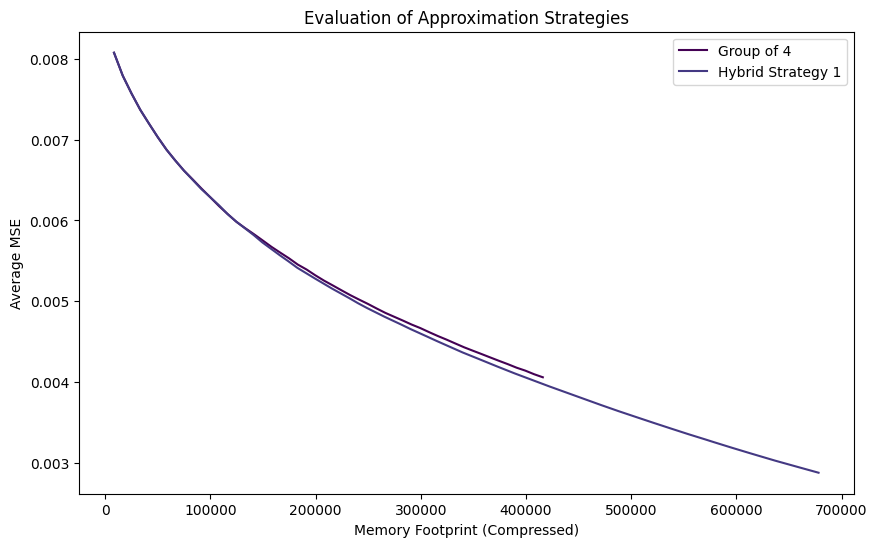

In [25]:
evaluation1(weight_array)

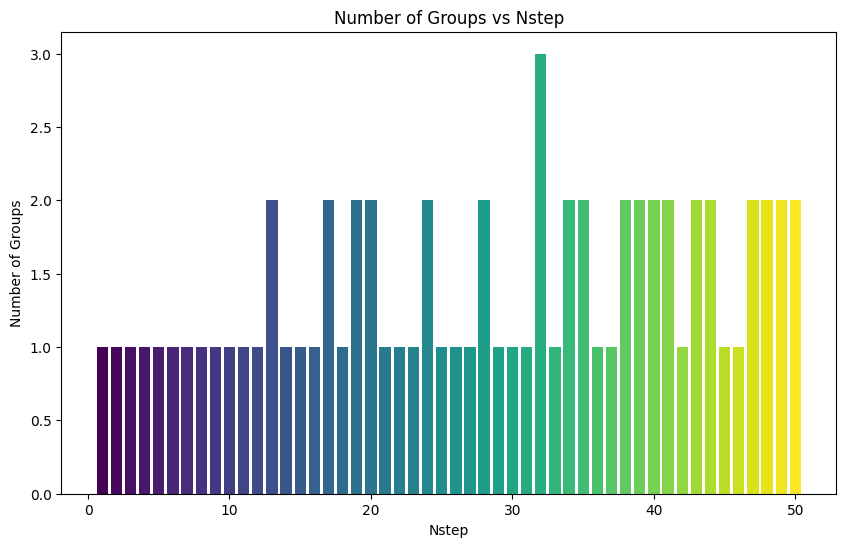

In [19]:
def evaluation3(weight_array,strategy):
    W = WeightArrayStep(weight_array,0.0001)
    Nsteps = range(1, 51)
    
    for step in Nsteps:
        W.hybrid_iterative_approximation_step(strategy)
        
    # Get a color map and generate a color for each bar
    colors = cm.viridis(np.linspace(0, 1, len(Nsteps)))

    plt.figure(figsize=(10, 6))
    plt.bar(Nsteps, W.num_group, color=colors)
    plt.xlabel('Nstep')
    plt.ylabel('Number of Groups')
    plt.title('Number of Groups vs Nstep')
    plt.show()


In [ ]:
evaluation3(weight_array,1)

In [ ]:
evaluation3(weight_array,3)

In [ ]:
evaluation3(weight_array,5)

In [ ]:
evaluation3(weight_array,6)